# Stochastic block model analysis using `graph-tool`

**Warning:** This notebook can only run on a Linux (or Mac OS) as the `graph-tool` module is not available on Windows

In [9]:
import graph_tool.all as gt
import sys
sys.path.append(r"../")

from analysis.analysis_utils import *

In [10]:
# Loading network from file
filepath = r"../out/last/E3O2P21R12T17_S75_T0.6_M1000_N1000000.h5"
adj_matrices, parameters = extract_all_info_from_hdf5(filepath)
niter = parameters["Number of interaction"]
size = parameters["Community size"]
phenotype_table = get_phenotype_table_from_parameters(parameters)

In [11]:
# Network to graph tool graph
edge_list = generate_edge_list_from_matrices(adj_matrices["peTotal"], adj_matrices["link"])
g = gt.Graph()
etrust = g.new_edge_property("double")
elink = g.new_edge_property("int")
g.edge_properties["trust"] = etrust
g.edge_properties["link"] = elink
g.add_edge_list(edge_list, eprops=[g.ep.trust, g.ep.link])

ph = g.new_vertex_property("string", vals=phenotype_table)
g.vertex_properties["Phenotype"] = ph

In [12]:
state = gt.minimize_nested_blockmodel_dl(g)

In [13]:
# For imporving the inference if needed

S1 = state.entropy()
for i in range(1000): # this should be sufficiently large
   state.multiflip_mcmc_sweep(beta=np.inf, niter=10)
S2 = state.entropy()

print("Improvement:", S2 - S1)

Improvement: 0.0


Tab10 colors:
- tab:blue : #1f77b4
- tab:orange : #ff7f0e
- tab:green : #2ca02c
- tab:red : #d62728
- tab:purple : #9467bd

In [14]:
# Setting color based on phenotype
color_dict = {
    "Envious": 'tab:blue',
    "Optimist": 'tab:orange',
    "Pessimist": 'tab:green',
    "Random": 'tab:red',
    "Trustful": 'tab:purple'
}
vcolors = []
for i in range(len(phenotype_table)):
    vcolors.append(color_dict[phenotype_table[i]])
vcolorp = g.new_vertex_property("string", vals=vcolors)

In [15]:
# Setting edges appearence
esizes = []
for i, j, t, l in edge_list:
    esizes.append(float(l))
esizep = g.new_edge_property('float', vals=esizes)

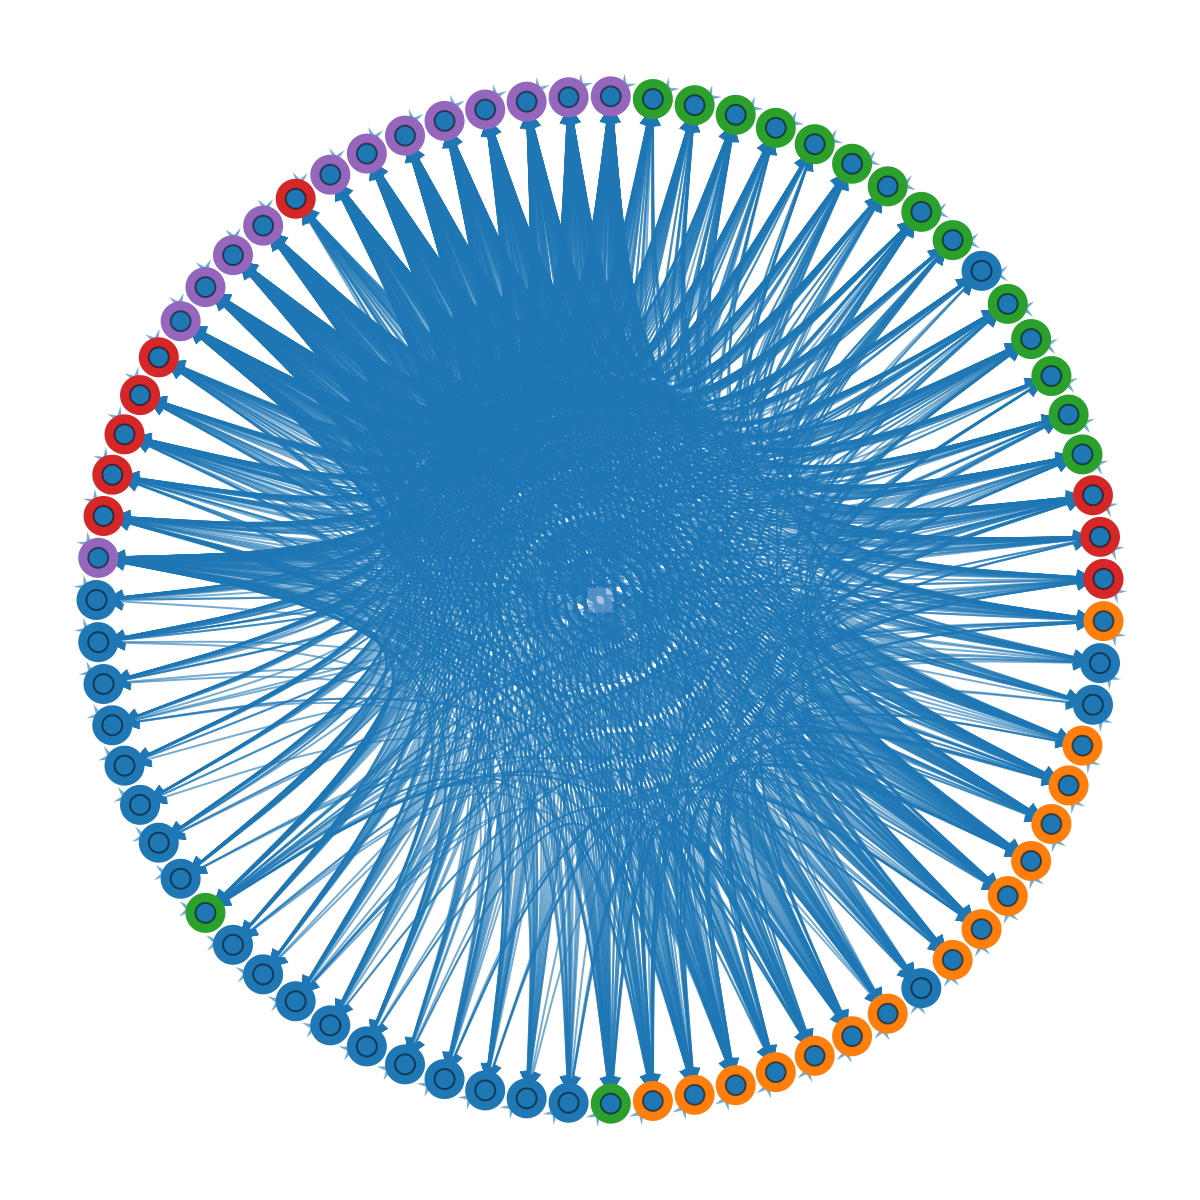

In [16]:
img = state.draw(
            inline=True, 
            vprops = {
                "size": 10,
                "halo": True,
                "halo_color": vcolorp,
                "halo_size": 2, 
                "color": [0, 0, 0, 0.5]
            },
            eprops= {
                "pen_width": esizep
            }
)